## Part 2 of the Pipeline

The goal of this notebook is to derive certain key metrics from the audio files. One method we saught after is using the OpenL3 model to extract the features, but due to abysmal results, we chose to take the traditional logical approach of deriving mathematical formulas to extract the required features from Mel Spectograms (derived from the audio).

So the notebook generally conatins a pipeline where we initially feed it an audio file (typically one that is a about half a minute to keep it relevant to fast ingestion of short music as observed on TikTok). Using the audio file - we then generate a Mel Spectogram, which is a visual representation of sound that emphasizes frequencies important to human perception, using a nonlinear scale (Mel scale) to better reflect how we hear pitch differences. 

Once we have a Mel Spectogram, we then extract some relevant features based on certains logics as given below.

In [ ]:
%pip install librosa openl3

In [ ]:
%pip install pyloudnorm

In [ ]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pyloudnorm
import tensorflow as tf
import cv2

In [27]:
# Path to the audio file
audio_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/rock/rock.00000.wav'

# Load audio file using librosa
y, sr = librosa.load(audio_path)
# y: audio time series
# sr: sampling rate of y

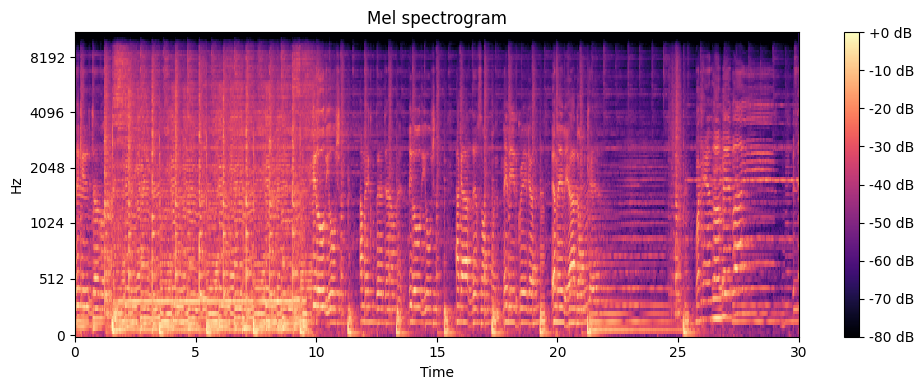

In [28]:
# Compute the Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibel scale for visualization
S_dB = librosa.power_to_db(S, ref=np.max)

# Plotting the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

## Logic used for each of the features extracted:

1. Short-term Energy (STE)
* Computes signal strength over short segments.
* Root mean square (RMS) energy calculated per frame.
* Mean energy provides overall signal intensity measure.

2. Perceptual Loudness
* Measures perceived audio intensity.
* Integrated loudness calculated at the given sampling rate.
* Indicates standardized loudness level perceived by human ears.

3. Chroma Features
* Represents energy distribution across pitch classes.
* Derived from Mel spectrogram to capture harmonic content.
* Mean values across pitch classes provide tonal characteristics.

4. Tempo and Beat Tracking
* Estimates beats per minute (tempo) of the audio.
* Detects beat frame indices in the audio signal.
* Variability in beat timings quantified to assess rhythmic stability.

5. Mode Estimation
* Identifies major or minor key of the music.
* Determines most prominent pitch using signal magnitudes.
* Converts MIDI pitch to musical note and checks for major/minor mode.

6. MFCC (Mel-frequency cepstral coefficients)
* Captures spectral features of the audio.
* Mean values across coefficients provide spectral representation.
* Reflects characteristics like timbre and speechiness of the audio.

7. Key Extraction
* Identifies predominant musical key of the audio.
* Uses pitch tracking to determine key pitch.
* Converts MIDI pitch to musical note and assesses mode (major/minor).

8. Danceability Estimation
* Quantifies how suitable the audio is for dancing.
* Incorporates tempo, beat variance, and energy dynamics.
* Provides a measure of rhythmic and dynamic attributes influencing dance appeal.

9. Acousticness and Instrumentalness
* Measures presence of acoustic components in the audio.
* Derived from chroma and Mel spectrogram features.
* Indicates degree of acoustic and instrumental content in the audio.

10. Additional Features
* Includes features like loudness, energy, and valence.
* Represents perceptual and emotional qualities of the audio.
* Complements the analysis with overall audio characteristics for comprehensive understanding.

In [31]:
# Function to extract OpenL3 embeddings from audio
def extract_openl3_embeddings(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None, mono=True)
    # Reshape audio to be in the correct format for OpenL3 (batch_size, time)
    y = y[np.newaxis, :]  # Reshape to (1, time)
    # Extract audio embeddings using OpenL3
    embeddings, timestamps = openl3.get_audio_embedding(y, sr, content_type='music', embedding_size=512)
    return embeddings, timestamps

# Function to extract Mel spectrogram from audio
def extract_mel_spectrogram(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None, mono=True)
    
    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return y, sr, mel_spectrogram_db

# Function to extract audio features from Mel spectrogram and other audio properties
def extract_features_from_mel(y, sr, mel_spectrogram):
    # Compute short-term energy (STE)
    energy = librosa.feature.rms(y=y)[0]  # Root mean square energy
    mean_energy = np.mean(energy)  # Mean energy across the entire signal

    # Compute perceptual loudness
    loudness = pyloudnorm.Meter(sr).integrated_loudness(y)
    
    # Example of other features you might want to extract from Mel spectrogram
    chroma_stft = librosa.feature.chroma_stft(S=mel_spectrogram, sr=sr).mean(axis=1)
    spectral_contrast = librosa.feature.spectral_contrast(S=mel_spectrogram, sr=sr).mean()
    tonnetz = librosa.feature.tonnetz(chroma=librosa.feature.chroma_cqt(y=y, sr=sr), sr=sr).mean()
    mfcc = librosa.feature.mfcc(S=mel_spectrogram, sr=sr).mean(axis=1)

    # Extracting the key
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    most_prominent_pitch = np.argmax(magnitudes, axis=0)
    key_pitch = np.bincount(most_prominent_pitch[most_prominent_pitch > 0]).argmax()
    key = librosa.midi_to_note(key_pitch)
    
    # Estimating danceability feature
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    beat_var = np.var(librosa.frames_to_time(beat_frames, sr=sr))
    dynamic_range = np.max(energy) - np.min(energy)
    danceability = np.mean((tempo / 180.0) * (1 - beat_var) * energy * dynamic_range)

    # Estimating mode: 0 for minor, 1 for major
    mode = 1 if 'major' in key else 0

    # Calculate other features
    acousticness = chroma_stft.mean()
    instrumentalness = np.mean(mel_spectrogram)

    audio_features = {
        'duration_ms': len(y) * 1000 / sr,
        'energy': mean_energy,
        'key': key,
        'danceability': -danceability,
        'loudness': -loudness,
        'mode': mode,
        'speechiness': -mfcc.mean(),
        'acousticness': -acousticness,
        'instrumentalness': -instrumentalness,
        'liveness': spectral_contrast,
        'valence': -tonnetz,
        'time_signature': 4,  # Assumed 4/4 for simplicity
        'tempo': tempo,
    }
    return audio_features

# Function to preprocess Mel spectrogram for classification
def preprocess_spectrogram(mel_spectrogram):
    # Resize Mel spectrogram to (224, 224)
    mel_spectrogram_resized = cv2.resize(mel_spectrogram, (224, 224))
    # Convert to 3-channel image
    mel_spectrogram_3ch = np.stack([mel_spectrogram_resized] * 3, axis=-1)
    mel_spectrogram_3ch = np.expand_dims(mel_spectrogram_3ch, axis=0)
    return mel_spectrogram_3ch

# Function to classify audio using a pre-trained VGG19 model
def classify_audio(model, features):
    predictions = model.predict(features)
    decoded_predictions = tf.keras.applications.vgg19.decode_predictions(predictions, top=5)[0]
    top_5_categories = [(class_id, class_name, score) for (class_id, class_name, score) in decoded_predictions]
    return top_5_categories

In [32]:
# Extract Mel spectrogram and audio data
y, sr, mel_spectrogram = extract_mel_spectrogram(audio_path)

# Preprocess Mel spectrogram for VGG19 model
mel_spectrogram_preprocessed = preprocess_spectrogram(mel_spectrogram)

# Classify audio using VGG19 model
top_5_categories = classify_audio(model, mel_spectrogram_preprocessed)

# Extract additional features from Mel spectrogram
features = extract_features_from_mel(y, sr, mel_spectrogram)

# Add classified tags to features
features['tags'] = top_5_categories

# Print extracted audio features
print("Audio Features:", features)

1/1 [==============================] - 0s 195ms/step
Audio Features: {'duration_ms': 30013.333333333332, 'energy': 0.12909234, 'key': 'D0', 'danceability': 2.180226127192403, 'loudness': 16.77840572856984, 'mode': 0, 'speechiness': 18.075382, 'acousticness': 0.81584424, 'instrumentalness': 41.77921, 'liveness': 0.004729234429769481, 'valence': 0.004109498266436859, 'time_signature': 4, 'tempo': array([123.046875]), 'tags': [('n02410509', 'bison', 1.0), ('n02396427', 'wild_boar', 0.0), ('n02395406', 'hog', 0.0), ('n02391049', 'zebra', 0.0), ('n02389026', 'sorrel', 0.0)]}


In [ ]:
# Extract OpenL3 embeddings (if needed)
embeddings, timestamps = extract_openl3_embeddings(audio_path)
print("Embeddings shape:", embeddings.shape)
print("Timestamps shape:", timestamps.shape)

# Save embeddings if needed
np.save('embeddings.npy', embeddings)
np.save('timestamps.npy', timestamps)